In [22]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("Distributions")
using Distributions
using Distributed
using DistributedArrays
using DistributedArrays.SPMD
#@everywhere using SharedArrays
@everywhere using Distributed
@everywhere using DistributedArrays
@everywhere using DistributedArrays.SPMD
using BenchmarkTools
using Base.Threads

In [23]:
include("aux_functions.jl")

reorder_particles!

In [24]:
order = 4
L = 100
#N = 200000
N = 20000
#J = 2048
#J = 1024
J = 512
#J = 128
vb = 3
dt = 0.1
t = 0.0
t_f = 20.0
M = 201
dt = t_f / (M-1)
t = 0.0
#M = convert(Int64,t_f/dt)
#M=1
κ = 2π/L
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)
M

201

In [25]:
E = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

r = L*rand(N);
vp = rand(Normal(vb,1),N÷2);
get_density!(r, n, p)
n0 = N/L
#get_ϕ!(ϕ, -n/n0 .+ 1., κ) # chenge the sign here to make it consistent with charge conservation and the time derivative of E
get_ϕ!(ϕ, n/n0 .- 1., κ)
get_E_from_ϕ!(ϕ,E,dx)

u0 = [r; -vp; vp; E];

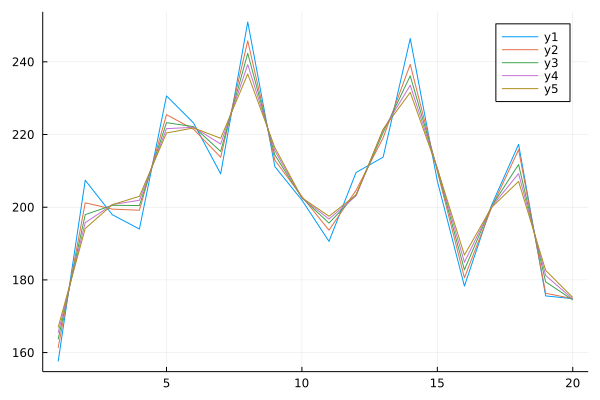

In [5]:
n_1 = zeros(J)
n_2 = zeros(J)
n_3 = zeros(J)
n_4 = zeros(J)
n_5 = zeros(J)

get_density!(u0,n_1, (L, N, J, κ, dx, 1))
get_density!(u0,n_2, (L, N, J, κ, dx, 2))
get_density!(u0,n_3, (L, N, J, κ, dx, 3))
get_density!(u0,n_4, (L, N, J, κ, dx, 4))
get_density!(u0,n_5, (L, N, J, κ, dx, 5))

plot(n_1[1:20])
plot!(n_2[1:20])
plot!(n_3[1:20])
plot!(n_4[1:20])
plot!(n_5[1:20])


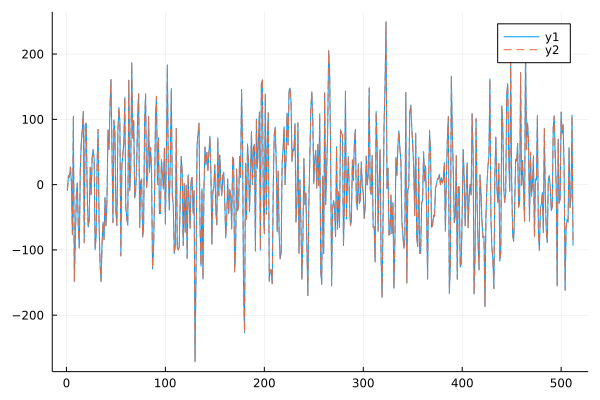

In [6]:
S_1 = zeros(J)
S_2 = zeros(J)

get_current_old!(u0,S_1,(L, N, J, κ, dx, 1)) #checking against old version
get_current!(u0,S_2,(L, N, J, κ, dx, 1))

plot(S_1)
plot!(S_2,ls=:dash)

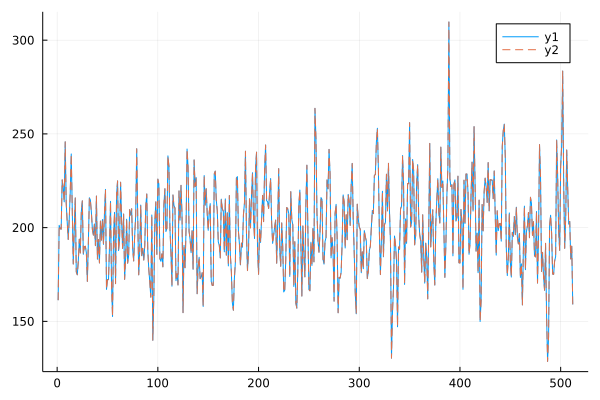

In [7]:
n_1 = zeros(J)
n_2 = zeros(J)

get_density_old!(u0,n_1,(L, N, J, κ, dx, 2)) #checking against old version (order 1 and 2 only)
get_density!(u0,n_2,(L, N, J, κ, dx, 2))

plot(n_1)
plot!(n_2,ls=:dash)

In [15]:
include("aux_functions.jl")
J = 20
N = 100
ω = 1.
a = 0.000
b = 0.
v = zeros(J)
x = [(i-1)/J*L for i in 1:J]
v = sin.(2π * ω * x/L) .+ b .+ a*x.*(L.-x)
s = L*rand(100)
for orden in 1:5
    vv1(y) = Interpolate_1(orden,v,y,J,L)
        println("orden = $orden, Error = $(sum(abs.(vv1.(s) - (sin.(2π * ω * s/L) .+ b + a*s.*(-s.+L)) ))/N)")
end

#plot(v)

orden = 1, Error = 0.0059088202270509375
orden = 2, Error = 0.008786988673149235
orden = 3, Error = 0.01169398390738321
orden = 4, Error = 0.014587239083522352
orden = 5, Error = 0.01746883745744946


In [9]:
for orden in 1:5
    vv2(y) = Interpolate_2(orden,v,y,J,L)
        println("orden = $orden, Error = $(sum(abs.(vv2.(s) - (sin.(2π * ω * s/L) .+ b + a*s.*(-s.+L)) ))/N)")
end

orden = 1, Error = 0.01149381285076322
orden = 2, Error = 0.014272278901637769
orden = 3, Error = 0.016642357570371528
orden = 4, Error = 0.018978862313478426
orden = 5, Error = 0.021304725020132302


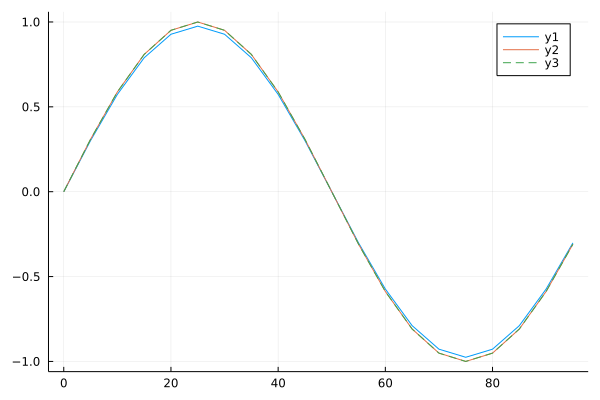

In [10]:
vv2(y) = Interpolate_2(1,v,y,J,L)
plot(x,vv2.(x))
plot!(x,sin.(2π * ω * x/L) .+ b .+ a*x.*(L.-x))
plot!(x,v,ls=:dash)

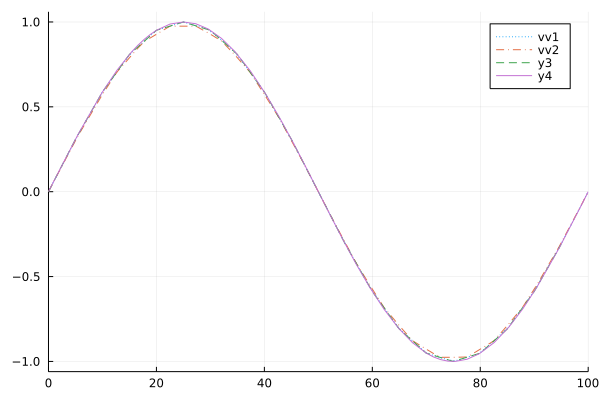

In [11]:
v1 = ones(J)
o = 1
vv1(y) = Interpolate_1(o,v,y,J,L)
vv2(y) = Interpolate_2(o,v,y,J,L)
plot(vv1,xlim=(0,100),ls=:dot, label = "vv1")
plot!(vv2,xlim=(0,100),ls=:dashdot, label = "vv2")
plot!(x,v, ls=:dash)
f(x) = sin(2π* ω*x/L) + b + a*x*(L-x)
plot!(f,xlim=(0,100))

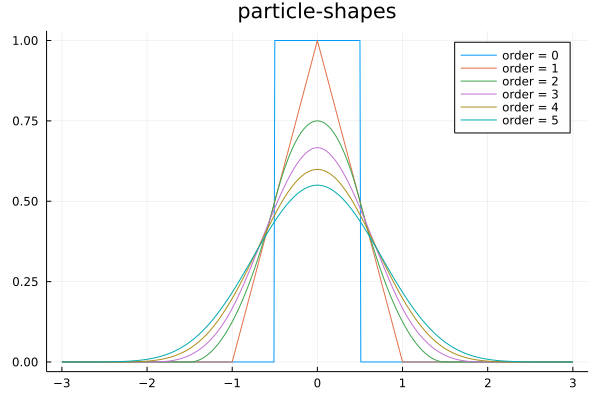

In [12]:
y = -3:0.01:3
plt = plot(title = "particle-shapes")
for order in 0:5
    plot!(plt,y,W.(order,y), label = "order = $order")
end
display(plt)
png("particle_shapes.png")

There is not much difference between the W and the W_alt, the second is a little better but not for much.

In [16]:
@btime get_current!(u0,n_2,(L, N, J, κ, dx, 5))

  40.401 μs (1 allocation: 64 bytes)


order 1: 6.769 μs (1 allocation: 64 bytes)

order 2: 9.643 μs (1 allocation: 64 bytes)

order 3: 11.992 μs (1 allocation: 64 bytes)

order 4: 28.049 μs (1 allocation: 64 bytes)

order 5: 40.742 μs (1 allocation: 64 bytes)

With W_alt

order 5: 40.401 μs (1 allocation: 64 bytes)


In [17]:
#ord = rand(1:5, 1000)

y = L*randn(10000)
diff = W.(5,y) - W_alt.(5,y)

diff'* diff

0.0

In [19]:
@btime W.(5,y)
@btime W_alt.(5,y)

  100.533 μs (239 allocations: 160.05 KiB)
  86.818 μs (239 allocations: 160.05 KiB)


10000-element Vector{Real}:
 0
 0
 0
 0
 0
 0
 5.236472073196456e-6
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

with order = 5, not much difference.

100.533 μs (239 allocations: 160.05 KiB)

86.818 μs (239 allocations: 160.05 KiB)


In [26]:
rr = 3*L*rand(10) .-L

10-element Vector{Float64}:
  86.90901602726748
  99.5116665993709
  14.69306506714085
 171.14408396517445
 198.0166640560335
  71.68419102005228
 -95.09922173846026
 -83.62005792920624
 160.22099651057903
  14.116922628307051

In [30]:
make_periodic!(rr,L) - make_periodic_old!(rr,L)

10-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0